In [49]:
import pandas as pd
import os

In [32]:
models = ["gpt-4o", "gpt-4o-mini", "llama3.1-8b-instruct-q4_0"]
setting = ["", "_no_name"]
results_path = "../results/llms"

In [ ]:
# load results
result_path = os.path.join(results_path, "run1")
results = {}
for model in models:
    for s in setting:
        result_file = os.path.join(result_path, f"{model}{s}_validation.csv")
        results[f"{model}{s}"] = pd.read_csv(result_file)

In [34]:
accuracy = {}

# calculate accuracy
for model in models:
    for s in setting:
        result = results[f"{model}{s}"]
        accuracy[f"{model}{s}"] = result["valid?"].sum() / len(result)

In [35]:
accuracy

{'gpt-4o': 0.7291666666666666,
 'gpt-4o_no_name': 0.6979166666666666,
 'gpt-4o-mini': 0.640625,
 'gpt-4o-mini_no_name': 0.6770833333333334,
 'llama3.1-8b-instruct-q4_0': 0.3385416666666667,
 'llama3.1-8b-instruct-q4_0_no_name': 0.3489583333333333}

In [99]:
def load_all_runs(num_runs=5):
    runs = []
    for i in range(1, num_runs + 1):
        result_path = os.path.join(results_path, f"run{i}")
        results = {}
        for model in models:
            for s in setting:
                result_file = os.path.join(result_path, f"{model}{s}_validation.csv")
                if os.path.exists(result_file):
                    results[f"{model}{s}"] = pd.read_csv(result_file)
        runs.append(results)
    return runs

def get_result(df):
    return df["valid?"].sum() / len(result)

In [100]:
solver_results = pd.read_csv("../results/smt/z3.csv")
solver_results["valid?"] = solver_results["sat"] != "unknown"

In [101]:
num_runs = 8

evaluation_results = []
for run in load_all_runs(num_runs):
    accuracy = {}
    for key in run.keys():
        result = run[key]
        accuracy[key] = get_result(result)
    evaluation_results.append(accuracy)

In [115]:
evaluation_results_cumulative = []
previous_results = {}
for run in load_all_runs(num_runs):
    accuracy = {}
    for key in run.keys():
        result = run[key]["valid?"] == 1
        if key in previous_results:
            result = result | previous_results[key]

        considered_result = [r for i, r in enumerate(result) if solver_results["sat"][i] == "sat"]
        accuracy[key] = sum(considered_result) / len(considered_result)
        previous_results[key] = result
    evaluation_results_cumulative.append(accuracy)

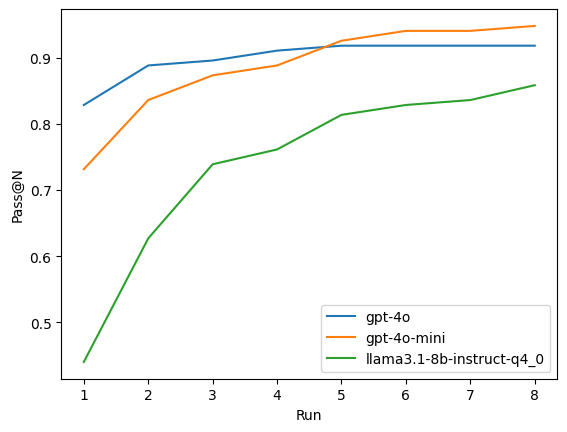

In [116]:
# plot the results for evaluaiton_results cumulative over runs on the same plot
import matplotlib.pyplot as plt

for model in models:
    for s in setting[:1]:
        values = []
        for run in evaluation_results_cumulative:
            if f"{model}{s}" in run:
                values.append(run[f"{model}{s}"])
        
        plt.plot(range(1, len(values) + 1), values, label=f"{model}{s}")

plt.xlabel("Run")
plt.ylabel("Pass@N")
plt.legend()

In [117]:
evaluation_results_cumulative = []
previous_results = {}
for run in load_all_runs(num_runs):
    accuracy = {}
    for key in run.keys():
        result = run[key]["valid?"] == 1
        if key in previous_results:
            result = result | previous_results[key]

        considered_result = [r for i, r in enumerate(result) if solver_results["sat"][i] == "unsat"]
        accuracy[key] = sum(considered_result) / len(considered_result)
        previous_results[key] = result
    evaluation_results_cumulative.append(accuracy)

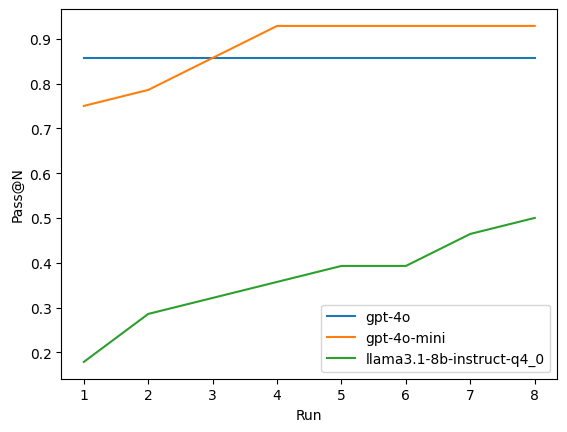

In [94]:
def map_to_label(row):
    if row["valid?"] == 1:
        return "sat"
    elif row["valid?"] == 0:
        return "unsat"
    else:
        return "unknown"

In [95]:
# create classification matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
run = load_all_runs(1)[0]
llm_prediction = run["gpt-4o"].apply(map_to_label, axis=1)

In [97]:
llm_prediction

0        sat
1        sat
2        sat
3        sat
4      unsat
       ...  
187      sat
188      sat
189      sat
190    unsat
191    unsat
Length: 192, dtype: object

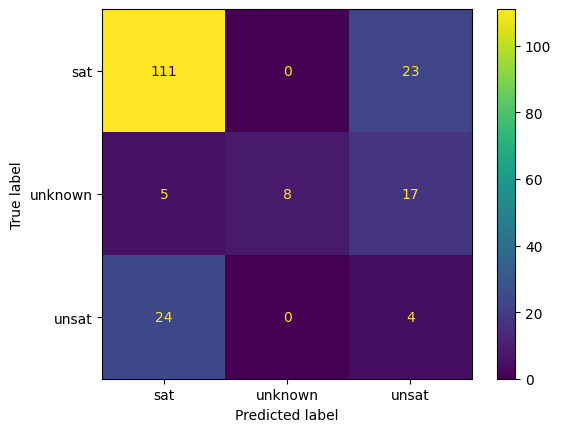

In [98]:
cm = confusion_matrix(solver_results["sat"], llm_prediction)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["sat", "unknown", "unsat"])

disp.plot()

In [82]:
print(classification_report(solver_results["sat"], llm_prediction))

              precision    recall  f1-score   support

         sat       0.84      0.96      0.90       134
     unknown       0.00      0.00      0.00        30
       unsat       0.63      0.86      0.73        28

    accuracy                           0.80       192
   macro avg       0.49      0.61      0.54       192
weighted avg       0.68      0.80      0.73       192



c:\Users\chenp\anaconda3\envs\string\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chenp\anaconda3\envs\string\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chenp\anaconda3\envs\string\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
solver_results["sat"]

,name,sat,result,truth_masks,valid?
0,Name,sat,"""Pc Z""","(True, True, True, True, True, True)",sat
1,Name,sat,"""Pl p""","(True, True, True, True, True, False)",sat
2,Name,sat,"""h S""","(True, True, True, True, False, True)",sat
3,Name,sat,"""b h""","(True, True, True, True, False, False)",sat
4,Name,unsat,NaN,"(True, True, True, False, True, True)",unsat
...,...,...,...,...,...
187,IBAN,sat,"""ABCDEFGHIJKLMNOPQRSTUV""","(True, False, False)",sat
188,IBAN,sat,"""121000""","(False, True, True)",sat
189,IBAN,sat,"""1210""","(False, True, False)",sat
190,IBAN,sat,"""ABCD00""","(False, False, True)",sat


In [71]:
llm_prediction

0      True
1      True
2      True
3      True
4      True
       ... 
187    True
188    True
189    True
190    True
191    True
Name: result, Length: 192, dtype: bool